# Seq2seq модели или

В этой тетрадке мы посмотрим на то, как в `pytorch` собрать сетку для автоперевода.

Автоперевод обладает [долгой и очень интересной историей.](https://vas3k.blog/blog/machine_translation/) Началось всё с того, что IBM в 1954 году заскамил правительство США. Все ждали революции в этой области и вливали в исследования кучу денег. На выходе получилось ["Она со мной углепластик" и "ПОТРАЧЕНО".](https://sampik.ru/articles/468-pochemu-piratskij-perevod-gtasa-takoj-strannyj.html)

Ну а революция свершилась только в 2015 году в Google. В этой тетрадке мы посмотрим на архитектуру с механизмом внимания благодаря которой произошел резкий скачок в качестве перевода и обучим её.


In [68]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## 1. Данные

Чтобы решать задачу автоперевода нам нужен корпус параллельных текстов. Они должны быть написаны на обоих языках. На том, с какого мы хотим переводить и на том, на какой мы хотим переводить. Есть разные базы данных, где подобные датасеты можной найти:

- Датасеты для [Anki-карточек](http://www.manythings.org/anki/)
- [OPUS](opus.nlpl.eu)
- [Стенограммы заседаний ООН](https://catalog.ldc.upenn.edu/LDC2013T06) и [Европейского союза.](http://www.statmt.org/europarl/)

Мы в этой тетрадке будем работать с Anki-карточками.

In [4]:
%%bash
wget -q http://www.manythings.org/anki/rus-eng.zip
unzip -q rus-eng.zip
rm rus-eng.zip
rm _about.txt
head rus.txt

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)
Go.	Иди.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)
Go.	Идите.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)
Hi.	Здравствуйте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)
Hi.	Привет!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)
Hi.	Хай.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)
Hi.	Здрасте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3803577 (marafon)
Hi.	Здоро́во!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3854188 (marafon)
Hi.	Приветик!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #7234283 (marafon)
Run!	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)


Внутри файла `rus.txt` лежат пары для перевода в формате:

```
Get down!	Ляг на пол!
```

Нам нужно считать все данные и предобработать их.

In [5]:
text_corpus = open('rus.txt').read().strip().split('\n')

# избавимся от значков копирайта
text_corpus = ['\t'.join(item.split('\t')[:-1]) for item in text_corpus]
len(text_corpus)

527642

In [6]:
text_corpus[424242] # нууу плииииииз :3

'I want you to go to Australia with me.\tЯ хочу, чтобы вы поехали в Австралию со мной.'

Когда текстов много их раскладывают по отдельным файликам и дальше итерируются по жёсткому диску. Мы делали похожим образом, когда работали с картинками. В датасете у нас хранились только названия файлов, а внутри него уже делалась подгрузка и предобработка. В нашем примере текстов мало. Поэтому сразу всё будем хранить в датасете.

Мы с вами знаем уже как минимум три способа токенизации. Можно бить тексты на символы, можно на слова, а можно делать BPE. В этом семинаре будем работать с отдельными словами. Но вам не должно составить труда переписать всё на BPE или любую другую токенизацию.

Не будем забывать про спец-символы, ознчающие неизвестные слова, начало строки, конец строки и паддинг. Для работы со словарями по каждому из языков создадим отдельный класс. На вход в него уже будем посылать предобработанные токены.

In [7]:
class LanguageIndex(object):
    """
    Класс для строительства мапинга
        индекс -> слово и слово -> индекс
    для каждого из языков
    """
    def __init__(self, tokens, lang):
        self.lang = lang
        self.specials = {'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3}

        self.token2indx = dict()
        self.indx2token = dict()

        self.__build_vocab(tokens)
        self.pad_index = self.token2indx['<pad>']
        self.unk_index = self.token2indx['<unk>']
        self.bos_index = self.token2indx['<bos>']
        self.eos_index = self.token2indx['<eos>']

    def __build_vocab(self, tokens):
        """Создаёт словарь токенов на основе корпуса и добавляет спецтокены."""
        vocab = set()
        for token_lst in tokens:
            vocab.update(token_lst)

        self.token2indx.update(self.specials)
        vocab_list = sorted(vocab)
        self.token2indx.update(dict(zip(vocab_list, range(4, len(vocab_list) + 4))))
        self.indx2token = {i: c for c, i in self.token2indx.items()}

    def __str_to_idx(self, tokens):
        """
        Преобразует список токенов в список индексов. Неизвестные токены заменяются на <unk>.
        """
        return [self.token2indx.get(tok, self.unk_index) for tok in tokens]

    def __idx_to_str(self, idx):
        """
        Преобразует список индексов обратно в токены. Неизвестные индексы заменяются на <unk>.
        """
        return [self.indx2token.get(index, '<unk>') for index in idx]

    def encode(self, tokens):
        """Добавляет <bos> и <eos>, затем переводит строку в индексы."""
        tokens = ['<bos>'] + list(tokens) + ['<eos>']
        return self.__str_to_idx(tokens)

    def decode(self, idx):
        """Переводит индексы обратно в строку, убирая спецтокены."""
        tokens = self.__idx_to_str(idx)
        return ' '.join(tok for tok in tokens if tok not in self.specials)

    @property
    def vocab_size(self):
        """Возвращает размер словаря."""
        return len(self.token2indx)


Теперь напишем датасет. При его создании будет происходить предобработка текстов и создание двух словарей.

In [8]:
class PairLanguagesDataset(Dataset):
    """Датасет для символьных моделей (например, RNN).
    Преобразует список строк в тензоры с паддингом и спецтокенами <bos>/<eos>/<pad>.
    """

    def __init__(self, texts, input_lang, target_lang):
        self.input_tokens = []
        self.target_tokens = []
        self.max_len_input = 0
        self.max_len_target = 0
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.__create_dataset(texts, input_lang, target_lang)

    def __preprocess_sentence(self, w):
        """Функция для предобработки предложения"""
        # уменьшаем регистр и убираем лишние пробелы
        w = w.lower().strip()
        # выкидываем все странные символы из рассмотрения
        w = re.sub(r"[^a-яА-Яa-zA-Z?.!,]+", " ", w).rstrip().strip()
        return word_tokenize(w)

    def __create_dataset(self, texts, input_lang, target_lang):
        """Создаем датасет для двух языков"""
        for text in texts:
            input_text, target_text = text.split('\t')
            input_w = self.__preprocess_sentence(input_text)
            target_w = self.__preprocess_sentence(target_text)

            self.input_tokens.append(input_w)
            self.target_tokens.append(target_w)
            self.max_len_input = max(self.max_len_input, len(input_w))
            self.max_len_target = max(self.max_len_target, len(target_w))

        self.input_vocab = LanguageIndex(self.input_tokens, input_lang)
        self.target_vocab = LanguageIndex(self.target_tokens, target_lang)

        # докинем <bos> и <eos>
        self.max_len_input = self.max_len_input + 2
        self.max_len_target = self.max_len_target + 2
        assert len(self.input_tokens) == len(self.target_tokens)

    def decode_pair(self, input_idx, target_idx):
        """ Декодирует пару последовательностей индексов обратно в текст."""
        if torch.is_tensor(input_idx):
            input_idx = input_idx.tolist()
        if torch.is_tensor(target_idx):
            target_idx = target_idx.tolist()

        input_text = self.input_vocab.decode(input_idx)
        target_text = self.target_vocab.decode(target_idx)
        return input_text, target_text

    def __len__(self):
        """Возвращает количество примеров в датасете."""
        return len(self.input_tokens)

    def __getitem__(self, item):
        """Возвращает паддированную последовательность и её реальную длину."""
        input_encoded = self.input_vocab.encode(self.input_tokens[item])
        input_padded = torch.full((self.max_len_input,), self.input_vocab.pad_index, dtype=torch.int64)
        input_padded[:len(input_encoded)] = torch.tensor(input_encoded)

        target_encoded = self.target_vocab.encode(self.target_tokens[item])
        target_padded = torch.full((self.max_len_target,), self.target_vocab.pad_index, dtype=torch.int64)
        target_padded[:len(target_encoded)] = torch.tensor(target_encoded)

        return input_padded, target_padded, len(input_encoded), len(target_encoded)

In [9]:
texts = [
    "Hello world\tПривет мир",
    "How are you?\tКак дела?",
    "I am fine\tЯ в порядке",
    "Good morning\tДоброе утро"
]

In [10]:
dataset = PairLanguagesDataset(
    texts,
    input_lang='en',
    target_lang='ru'
)

# Информация о словарях
print(f"\nInput vocabulary size: {dataset.input_vocab.vocab_size}")
print(f"Target vocabulary size: {dataset.target_vocab.vocab_size}")


Input vocabulary size: 15
Target vocabulary size: 14


In [11]:
# Получение одного примера
input_padded, target_padded, input_len, target_len = dataset[0]

print(f"\nExample 0:")
print(f"Input shape: {input_padded.shape}, length: {input_len}")
print(f"Target shape: {target_padded.shape}, length: {target_len}")


Example 0:
Input shape: torch.Size([6]), length: 4
Target shape: torch.Size([5]), length: 4


In [12]:
# Декодирование обратно
input_text, target_text = dataset.decode_pair(input_padded, target_padded)
print(f"Decoded input: {input_text}")
print(f"Decoded target: {target_text}")

Decoded input: hello world
Decoded target: привет мир


In [13]:
# Проверка на неизвестных словах
dataset.input_vocab.encode(["hello", "kid"])

[2, 9, 1, 3]

In [14]:
print(dataset.input_vocab.indx2token[2])
print(dataset.input_vocab.indx2token[9])
print(dataset.input_vocab.indx2token[1])
print(dataset.input_vocab.indx2token[3])

<bos>
hello
<unk>
<eos>


Чтобы хоть что-то обучилось за обозримое время, ограничимся только частью наблюдений.

In [16]:
from torch.utils.data import DataLoader, random_split

dataset = PairLanguagesDataset(text_corpus[:10000], 'en', 'ru')

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [17]:
dataloader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=2048, shuffle=False)

In [18]:
# Размеры словарей (сколько уникальных токенов)
print(f"Input vocab size: {train_dataset.dataset.input_vocab.vocab_size}")
print(f"Output vocab size: {train_dataset.dataset.target_vocab.vocab_size}")

Input vocab size: 1711
Output vocab size: 4636


## 2. Архитектура сетки

Наша нейросетка будет состоять из двух частей: энкодер будет перегонять текст на первом языке в эмбединги. Декодер будет раскодировать эти эмбединги в текст на новом языке

<img src="https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/encdec.jpg" width="500" alt="attention mechanism">

Можно собрать обе части в виде рекуррентных нейронных сеток. При обучении модели мы будем скармливать энкодеру предложение для перевода. Он просто будет обновлять скрытые состояния и передавать их в декодер. Декодер будет съедать текст, который должен получиться в качестве перевода и прогнозировать в нём следуюшее слово.

<img src="https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/seq2seq.jpg" width="500" alt="attention mechanism">

При инференсе мы будем просто генерировать второе предложение по одному слову и подставлять в следующий шаг прогноз.

<img src="https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/greedy_dec.jpg" width="350" alt="attention mechanism">



Архитектуру можно усложнить и добавить в неё механизм внимания, который вы обсуждали на лекции. Именно такую архитектуру мы соберём ниже.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

Почитать про это подробнее с красивыми картинками и анимациями можно [в ШАДовском курсе по NLP Лены Войты.](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

Начнём с энкодера.

In [19]:
class EncoderRNN(nn.Module):
    """
    Энкодер на основе GRU.
    Args:
        input_size: размер входного словаря (vocab size)
        hidden_size: размерность скрытого состояния GRU
        dropout_p: вероятность dropout для регуляризации
    """
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding слой: преобразует индексы токенов в векторы
        self.embedding = nn.Embedding(input_size, hidden_size)

        # GRU слой: обрабатывает последовательность векторов
        # batch_first=True означает, что входной тензор имеет форму (batch, seq, feature)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p) # немного регуляризации

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))

        # output содержит скрытые состояния для КАЖДОГО временного шага
        # hidden содержит только ПОСЛЕДНЕЕ скрытое состояние
        output, hidden = self.gru(embedded)
        return output, hidden

Реализуем механизм внимания Богданова.

> Да-да, не Багданау, а Богданова. Этот механизм внимания в 2014 году в Монреале под руководством Йошуа Бенжио придумал выходец из Беларуси Дима Богданов.

In [ ]:
class BahdanauAttention(nn.Module):
    """
    Механизм внимания Bahdanau (аддитивное внимание).
    Вычисляет, на какие части входной последовательности должен "обратить внимание"
    декодер при генерации текущего токена выхода.

    Формула:
        score = Va * tanh(Wa * query + Ua * keys)
        weights = softmax(score)
        context = sum(weights * keys)

    Args:
        hidden_size: размерность скрытых состояний
    """
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Ua = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Va = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, query, keys):
        """
        Args:
            query: (batch_size, 1, hidden_size) - текущее состояние декодера
            keys: (batch_size, seq_len, hidden_size) - все выходы энкодера

        Returns:
            context: (batch_size, 1, hidden_size) - взвешенная сумма выходов энкодера
            weights: (batch_size, 1, seq_len) - веса внимания (какие части входа важны)
        """
        # scores: (batch, seq_len, 1)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))

        # меняем форму для softmax: (batch, 1, seq_len)
        scores = scores.squeeze(2).unsqueeze(1)

        # Применяем softmax, чтобы получить веса (сумма = 1)
        # weights: (batch, 1, seq_len)
        weights = F.softmax(scores, dim=-1)

        # Вычисляем контекстный вектор как взвешенную сумму
        # bmm = batch matrix multiplication
        # weights: (batch, 1, seq_len) x keys: (batch, seq_len, hidden)
        # = context: (batch, 1, hidden)
        context = torch.bmm(weights, keys)
        return context, weights

Засунем всё это в декодер.

In [21]:
class AttnDecoderRNN(nn.Module):
    """
    Декодер с механизмом внимания.
    Args:
        hidden_size: размерность скрытых состояний
        output_size: размер выходного словаря (vocab size)
        dropout_p: вероятность dropout
        max_length: максимальная длина генерируемой последовательности
    """
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=50):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)

        # GRU получает конкатенацию embedded токена и контекстного вектора
        # Поэтому входная размерность = 2 * hidden_size
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)

        # Выходной слой: предсказываем следующий токен
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
        self.max_length = max_length


    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None, bos_token=2, device='cpu'):
        """
        Полный прогон декодера (обучение или инференс).
        Args:
            encoder_outputs: (batch, src_len, hidden) - все выходы энкодера
            encoder_hidden: (1, batch, hidden) - финальное состояние энкодера
            target_tensor: (batch, trg_len) - целевая последовательность (для teacher forcing)
                          Если None, то используем greedy decoding (жадный выбор)
            bos_token: индекс токена начала последовательности <bos>
            device: устройство (cpu/cuda)

        Returns:
            decoder_outputs: (batch, trg_len, vocab_size) - логарифмы вероятностей для каждого токена
            decoder_hidden: (1, batch, hidden) - финальное скрытое состояние декодера
            attentions: (batch, trg_len, src_len) - веса внимания для визуализации
        """

        # Первый вход декодера - токен <bos> (начало последовательности)
        # Создаём тензор формы (batch_size, 1) заполненный индексом bos_token
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(bos_token)

        # Инициализируем скрытое состояние декодера состоянием энкодера
        decoder_hidden = encoder_hidden

        # Списки для накопления выходов и весов внимания
        decoder_outputs = []
        attentions = []

        # Определяем длину генерации
        # Если есть target (обучение), генерируем столько же токенов
        # Если нет (инференс), генерируем до max_length
        max_len = target_tensor.size(1) if target_tensor is not None else self.max_length

        # Генерируем по одному токену за раз
        for i in range(max_len):
            # Один шаг декодирования
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Сохраняем выход и веса внимания
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: используем настоящий токен как следующий вход
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: используем токен с максимальной вероятностью как следующий вход
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach чтобы не вычислять градиенты

        # Объединяем все выходы в один тензор
        # decoder_outputs: list of (batch, 1, vocab_size) -> (batch, trg_len, vocab_size)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)

        # Применяем log_softmax для получения логарифмов вероятностей
        # Это нужно для NLLLoss (Negative Log Likelihood Loss)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

        # Объединяем веса внимания
        # attentions: list of (batch, 1, src_len) -> (batch, trg_len, src_len)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        """
        Один шаг декодирования.
        Args:
            input: (batch, 1) - текущий входной токен
            hidden: (1, batch, hidden) - текущее скрытое состояние
            encoder_outputs: (batch, src_len, hidden) - выходы энкодера

        Returns:
            output: (batch, 1, vocab_size) - распределение вероятностей для следующего токена
            hidden: (1, batch, hidden) - обновлённое скрытое состояние
            attn_weights: (batch, 1, src_len) - веса внимания
        """
        # Преобразуем входной токен в вектор
        # (batch, 1) -> (batch, 1, hidden)
        embedded = self.dropout(self.embedding(input))

        # Подготавливаем query для attention (текущее состояние декодера)
        # hidden: (1, batch, hidden) -> (batch, 1, hidden)
        query = hidden.permute(1, 0, 2)

        # Вычисляем контекстный вектор с помощью attention
        # context: (batch, 1, hidden) - какие части входа важны сейчас
        # attn_weights: (batch, 1, src_len) - веса для каждой позиции входа
        context, attn_weights = self.attention(query, encoder_outputs)

        # Конкатенируем embedded токен и контекстный вектор
        # embedded: (batch, 1, hidden) + context: (batch, 1, hidden)
        # = input_gru: (batch, 1, 2*hidden)
        input_gru = torch.cat((embedded, context), dim=2)

        # Прогоняем через GRU
        # output: (batch, 1, hidden)
        # hidden: (1, batch, hidden)
        output, hidden = self.gru(input_gru, hidden)

        # Преобразуем в распределение по словарю
        # output: (batch, 1, hidden) -> (batch, 1, vocab_size)
        output = self.out(output)

        return output, hidden, attn_weights

Скрепляем модели вместе!

In [22]:
class Seq2SeqWithAttention(nn.Module):
    """Seq2Seq модель с механизмом внимания"""
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, bos_token, teacher_forcing_ratio=0.5):
        """
        Args:
            src: (batch_size, src_len) - входная последовательность
            trg: (batch_size, trg_len) - целевая последовательность (может быть None для инференса)
            bos_token: индекс токена <bos>
            teacher_forcing_ratio: вероятность использования teacher forcing
        """
        # Энкодер
        encoder_outputs, encoder_hidden = self.encoder(src)

        # Случайно решаем, использовать ли teacher forcing на этом батче (чтобы не переобучиться)
        if trg is not None and random.random() < teacher_forcing_ratio:
            # С teacher forcing: подаём реальные токены
            decoder_outputs, decoder_hidden, attentions = self.decoder(
                encoder_outputs, encoder_hidden, trg, bos_token, self.device
            )
        else:
            # Без teacher forcing: используем предсказания модели
            decoder_outputs, decoder_hidden, attentions = self.decoder(
                encoder_outputs, encoder_hidden, None, bos_token, self.device
            )

        return decoder_outputs, attentions

## 3. Обучение

Напишем цикл для обучения моделей.

In [23]:
def train_epoch(model, dataloader, optimizer, criterion, device, bos_token, clip=1):
    """
    Одна эпоха обучения.
    """
    model.train()
    epoch_loss = 0

    for src, trg, src_len, trg_len in dataloader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output, attentions = model(src, trg, bos_token, teacher_forcing_ratio=0.5)

        # Игнорируем первый токен (<bos>), так как его не нужно предсказывать
        # Преобразуем в 2D тензоры для CrossEntropyLoss/NLLLoss
        output = output[:, 1:].reshape(-1, output.shape[-1])  # (batch * (trg_len-1), vocab_size)
        trg = trg[:, 1:].reshape(-1)  # (batch * (trg_len-1))

        # NLLLoss ожидает log-вероятности (которые выдаёт decoder) и истинные индексы
        loss = criterion(output, trg)

        loss.backward()

        # обрезаем градиенты, чтобы предотвратить "взрыв градиентов"
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [24]:
def evaluate(model, dataloader, criterion, device, bos_token):
    """
    Оценка модели на валидационных данных.
    """

    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg, src_len, trg_len in dataloader:
            src, trg = src.to(device), trg.to(device)

            # никакого teacher forcing, только свои предсказания
            output, attentions = model(src, trg, bos_token, teacher_forcing_ratio=0)

            # подготовка данных и вычисление loss (как в train_epoch)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [93]:
def translate(model, sentence, dataset, device, max_len=50, visual=False):
    """
    Перевод одного предложения.
    Args:
        model: обученная модель
        sentence: строка на входном языке
        dataset: датасет (для доступа к vocab и preprocessing)
        device: устройство
        max_len: максимальная длина генерируемого перевода
        visual: надо ли рисовать картинку

    Returns:
        translation: строка с переводом
    """

    model.eval()

    # Препроцессинг предложения (как в датасете)
    w = sentence.lower().strip()
    w = re.sub(r"[^a-яА-Яa-zA-Z?.!,]+", " ", w).rstrip().strip()
    tokens = word_tokenize(w) if w else []

    if not tokens:
        return ""

    # Кодируем токены в индексы + добавляем padding
    input_encoded = dataset.dataset.input_vocab.encode(tokens)

    input_tensor = torch.full(
        (1, dataset.dataset.max_len_input),  # batch_size=1
        dataset.dataset.input_vocab.pad_index,
        dtype=torch.long
    ).to(device)

    input_tensor[0, :len(input_encoded)] = torch.tensor(input_encoded, dtype=torch.long)

    with torch.no_grad():
        # ШАГ 1: Энкодер обрабатывает входную последовательность
        encoder_outputs, encoder_hidden = model.encoder(input_tensor)

        # ШАГ 2: Инициализация декодера, Начинаем с токена <bos>
        decoder_input = torch.tensor([[dataset.dataset.target_vocab.bos_index]], device=device)
        decoder_hidden = encoder_hidden

        # ШАГ 3: Генерируем перевод токен за токеном
        decoded_tokens = []
        attentions_list = []
        for _ in range(max_len):
            # шаг декодирования
            decoder_output, decoder_hidden, attn_weights = model.decoder.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # применяем log_softmax для получения вероятностей
            decoder_output = F.log_softmax(decoder_output, dim=-1)

            # выбираем токен с максимальной вероятностью (greedy decoding)
            top1 = decoder_output.argmax(2)

            # проверяем, не сгенерировали ли мы токен конца последовательности
            if top1.item() == dataset.dataset.target_vocab.eos_index:
                break

            # cохраняем токен и веса внимания
            decoded_tokens.append(top1.item())
            attentions_list.append(attn_weights.squeeze().cpu().numpy())

            # используем сгенерированный токен как вход на следующем шаге
            decoder_input = top1

    # ШАГ 4: декодируем индексы обратно в текст
    translation = dataset.dataset.target_vocab.decode(decoded_tokens)

    # ШАГ 5: картиночка
    if visual:
        # (output_len, input_len)
        attention_matrix = np.array(attentions_list)

        # токены
        input_tokens_viz = ['<bos>'] + tokens + ['<eos>']
        input_tokens_viz = input_tokens_viz[:len(input_encoded)]
        output_tokens_viz = [dataset.dataset.target_vocab.indx2token[idx] for idx in decoded_tokens]

        # Обрезаем attention до реальных размеров
        attention_matrix = attention_matrix[:len(output_tokens_viz), :len(input_tokens_viz)]

        fig, ax = plt.subplots(figsize=(6,6))
        sns.heatmap(
            attention_matrix,
            xticklabels=input_tokens_viz,
            yticklabels=output_tokens_viz,
            cmap='Blues',
            cbar=False,
            square=True,
            linewidths=0.5,
            linecolor='white',
            ax=ax,
            vmin=0,
            vmax=1,
            annot=True,  # Показываем значения
            fmt='.2f'    # 2 знака после запятой
        )

        ax.set_xlabel('Input', fontsize=12, fontweight='bold')
        ax.set_ylabel('Output', fontsize=12, fontweight='bold')
        ax.set_title('Attention Weights', fontsize=14, fontweight='bold', pad=15)

        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    return translation

In [48]:
INPUT_DIM = train_dataset.dataset.input_vocab.vocab_size
OUTPUT_DIM = train_dataset.dataset.target_vocab.vocab_size
MAX_LENGTH = train_dataset.dataset.max_len_target
BOS_TOKEN = train_dataset.dataset.target_vocab.bos_index

HIDDEN_SIZE = 256
DROPOUT = 0.3

print(f"Input vocab size: {INPUT_DIM}")
print(f"Output vocab size: {OUTPUT_DIM}")
print(f"Max length: {MAX_LENGTH}\n")

Input vocab size: 1711
Output vocab size: 4636
Max length: 12



In [49]:
encoder = EncoderRNN(INPUT_DIM, HIDDEN_SIZE, DROPOUT)
decoder = AttnDecoderRNN(HIDDEN_SIZE, OUTPUT_DIM, DROPOUT, MAX_LENGTH)
model = Seq2SeqWithAttention(encoder, decoder, device).to(device)

# число обучаемых параметров
sum(p.numel() for p in model.parameters() if p.requires_grad)

3934237

In [50]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# NLLLoss (Negative Log Likelihood) для работы с log_softmax
# ignore_index=pad_index означает, что паддинг токены не влияют на loss
criterion = nn.NLLLoss(ignore_index=train_dataset.dataset.target_vocab.pad_index)

In [51]:
N_EPOCHS = 50
best_val_loss = float('inf')  # Для сохранения лучшей модели

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # Обучаем одну эпоху
    train_loss = train_epoch(
        model, dataloader_train, optimizer, criterion, device, BOS_TOKEN
    )

    # Оцениваем на валидации
    val_loss = evaluate(model, dataloader_val, criterion, device, BOS_TOKEN)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    # Сохраняем модель, если val_loss улучшился
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best-attention-model.pt')

    # Выводим прогресс каждые 10 эпох
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')

        # PPL (Perplexity) = exp(loss) - чем меньше, тем лучше
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {torch.exp(torch.tensor(train_loss)):.3f}')
        print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {torch.exp(torch.tensor(val_loss)):.3f}')


Epoch: 10 | Time: 0m 3s
	Train Loss: 1.216 | Train PPL: 3.372
	 Val. Loss: 2.514 |  Val. PPL: 12.349
Epoch: 20 | Time: 0m 3s
	Train Loss: 0.598 | Train PPL: 1.819
	 Val. Loss: 2.570 |  Val. PPL: 13.068
Epoch: 30 | Time: 0m 4s
	Train Loss: 0.482 | Train PPL: 1.619
	 Val. Loss: 2.734 |  Val. PPL: 15.393
Epoch: 40 | Time: 0m 3s
	Train Loss: 0.451 | Train PPL: 1.570
	 Val. Loss: 2.825 |  Val. PPL: 16.869
Epoch: 50 | Time: 0m 5s
	Train Loss: 0.413 | Train PPL: 1.511
	 Val. Loss: 2.949 |  Val. PPL: 19.095


In [52]:
# загружаем лучший чекпойнт
model.load_state_dict(torch.load('best-attention-model.pt'))

<All keys matched successfully>

In [65]:
test_sentences = [
    "thank you",
    "good morning",
    "i love you",
    "i wow you"
]

In [85]:
# Переводим каждое предложение
for sentence in test_sentences:
    translation = translate(model, sentence, train_dataset, device, max_len=MAX_LENGTH)
    print(f"EN: {sentence:15} -> RU: {translation}")

EN: thank you       -> RU: вы спасибо .
EN: good morning    -> RU: доброе доброе !
EN: i love you      -> RU: я обожаю тебя .
EN: i wow you       -> RU: я я вам тебя ?


Сделаем то же самое с визуализацией внимания.

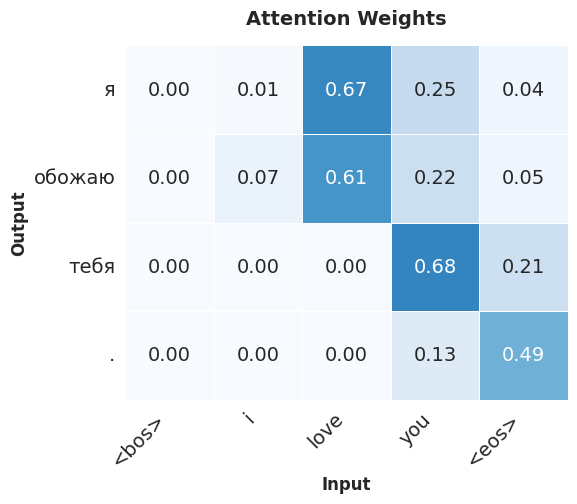

'я обожаю тебя .'

In [94]:
translate(model, "i love you", train_dataset, device, max_len=MAX_LENGTH, visual=True)